In [3]:
import numpy as np
# import scipy
from scipy.ndimage import gaussian_filter1d as g_filter
# from astropy import units as u
import matplotlib.pyplot as plt
# import pandas as pd
from tools.file_finder import find_file
import ipywidgets as wwid

In [49]:
date = "210513"
date2 = "210611"; date3 = "210610"
date4 = "210621"; date5 = "210625"
date6 = "210810"; date7 = "210831"
date8 = "210903"; date9 = "210907"
date10 = "210910"; date11 = "210914"
date12 = "210917"; date13 = "210921"
date14 = "210928"; date15 = "211001"
date16 = "211005"; date17 = "211015"
date18 = "211019"; date19 = "211022"

keys = [
    # (49, date15),
    # (50, date15),
    # (77, date16),
    # (4, date17),
    (14, date11),
    (35, "211001"),
    (36, "211001"),
    (62, "211025"),
    (63, "211025"),
    (125, date18),
    (3, date19),
    (24, date19)
]


In [61]:
import datetime
td = datetime.datetime.now() + datetime.timedelta(days=2)
td.strftime("%y%m%d")

'211101'

In [50]:

odmr_paths = [
    find_file("ODMR", *key, contains="Counts") for key in keys
]

# keys = [f"{n}_{d}" for (n, d) in keys]

DI = lambda n, date : keys.index((int(n), date))
odmr_specs = [
    np.genfromtxt(f) for f in odmr_paths
]

num_not_final = len(odmr_specs)
swp_spcs = slice(0, num_not_final) # Later we will want to only fetch specs from this original list

freq_axes = [spec[0] for spec in odmr_specs]
odmr_specs = [spec[1:] for spec in odmr_specs]

final_paths = []
    # "ODMR_3_2peaks.txt", #"ODMR_4_same_as_3.txt"
# ]
final_specs = [
    np.genfromtxt(f, skip_header=18).T for f in final_paths
]
freq_axes += [spec[0] for spec in final_specs]
odmr_specs += [spec[1].reshape(1,-1) for spec in final_specs]
odmr_paths += final_paths
odmr_paths  = [path[-30:] for path in odmr_paths]


# odmr_specs[-2].shape

## Plot Counts for each:

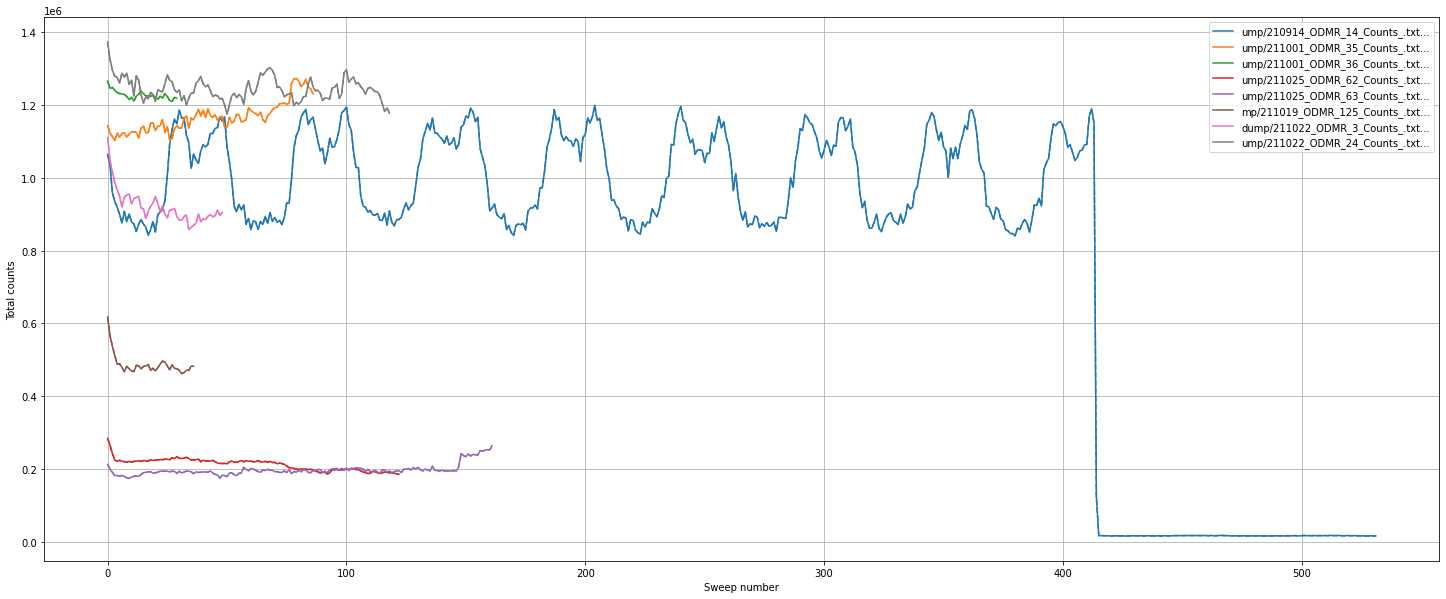

In [51]:
plt.figure(figsize=(25, 10))

range_selections = [slice(None, None, None) for _ in odmr_specs]
sweep_counts = [spec.sum(axis=1) for spec in odmr_specs]

# range_selections[DI(125, "211019")] = slice(None, 3)
# range_selections[DI(3, date19)] = slice(None, 3)
# range_selections[DI(63, "211025")] = slice(None, 10)
# range_selections[DI(62, "211025")] = slice(None, 10)

for spec, lbl, rng in zip(odmr_specs[swp_spcs], odmr_paths[swp_spcs], range_selections):
    sweep_counts = spec.sum(axis=1)
    sweep_ax = np.arange(len(sweep_counts))
    f, = plt.plot(sweep_counts, '--')
    plt.plot(sweep_ax[rng], sweep_counts[rng], f.get_color(), label=lbl[:30]+'...')

plt.legend()
plt.grid()
plt.xlabel("Sweep number")
plt.ylabel("Total counts")
# plt.xlim(200, 600)
plt.show()


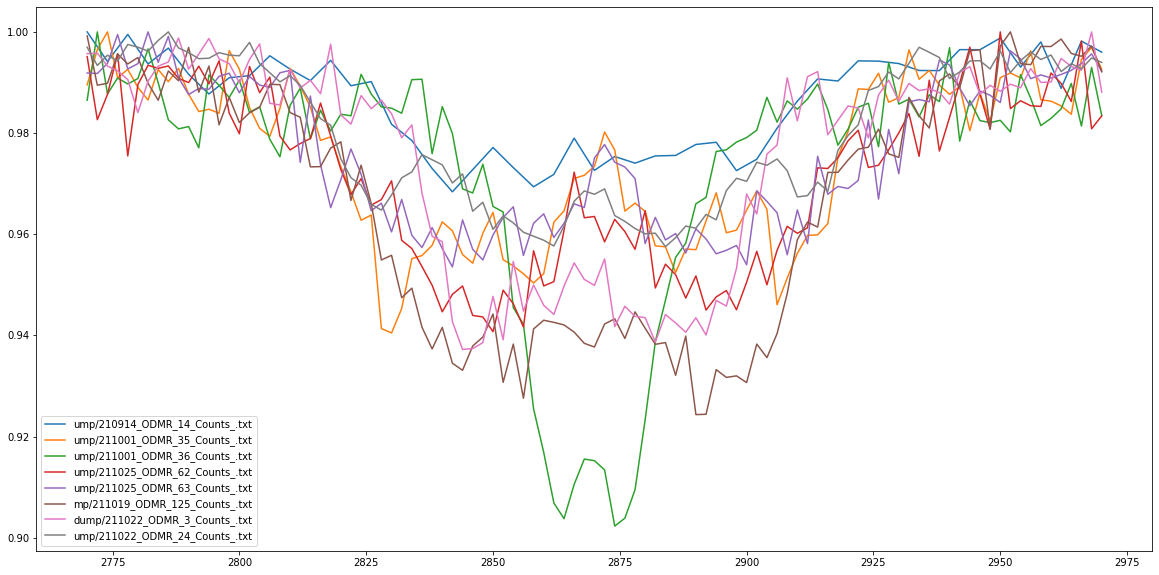

In [52]:
plt.figure(figsize=(20, 10))

full_specs = []

good_specs = [i for i in range(len(odmr_paths))]
# good_specs.remove(DI(23, date8))
# good_specs.remove(DI(22, date8))
# good_specs.remove(DI(11, "210831"))
# good_specs.remove(DI(3, "210910"))
# good_specs.remove(DI(4, "210910"))
# good_specs.remove(DI(6, "210910"))
# good_specs.remove(DI(7, "210910"))
# good_specs.remove(DI(8, "210910"))
# good_specs.remove(DI(16, "210910"))

for i, (freq, spec, selection) in enumerate(zip(freq_axes, odmr_specs, range_selections)):
    normd = spec[selection]
    normd /= normd.max(axis=1, keepdims=True)
    full_spec = normd.sum(axis=0)
    # smooth
    # full_spec = g_filter(full_spec, 1)
    # full_spec /= spec[selection].shape[1]
    full_spec /= max(full_spec)
    full_specs.append(full_spec)
    if i in good_specs:
        plt.plot(freq, full_spec, label=odmr_paths[i])

full_good_specs = [full_specs[i] for i in good_specs]
good_freqs = [freq_axes[i] for i in good_specs]

    
plt.legend()
plt.show()




<Figure size 432x288 with 0 Axes>

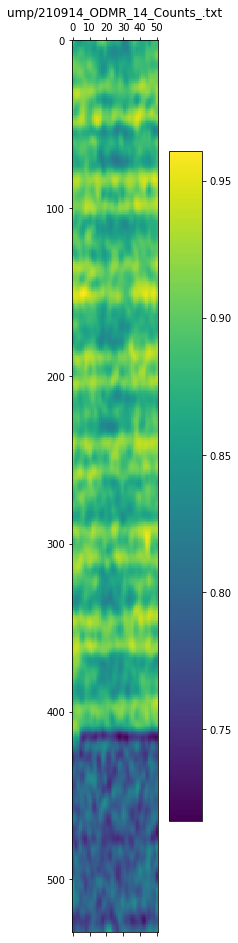

<Figure size 432x288 with 0 Axes>

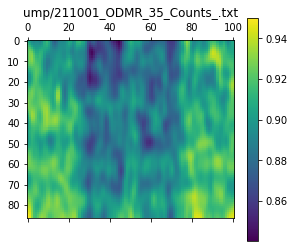

<Figure size 432x288 with 0 Axes>

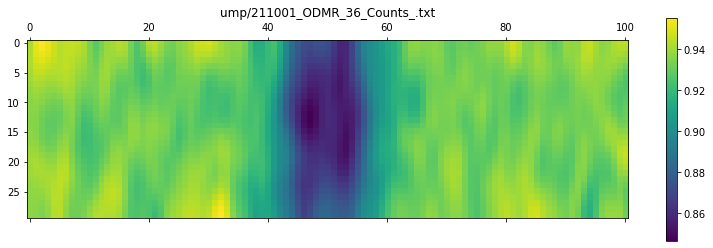

<Figure size 432x288 with 0 Axes>

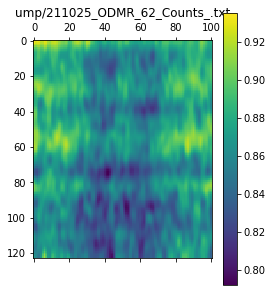

<Figure size 432x288 with 0 Axes>

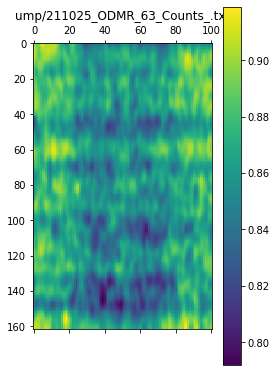

<Figure size 432x288 with 0 Axes>

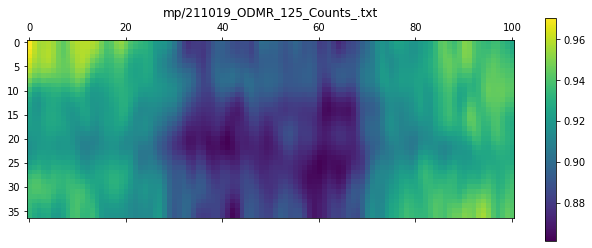

<Figure size 432x288 with 0 Axes>

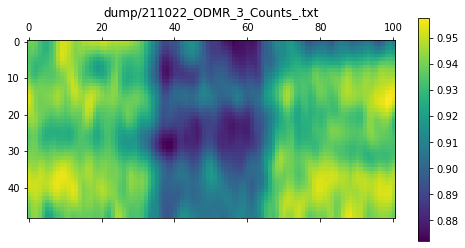

<Figure size 432x288 with 0 Axes>

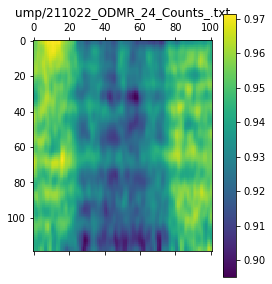

In [53]:
from scipy.ndimage import gaussian_filter as g2_filter
for title, spec in zip(odmr_paths, odmr_specs):
    plt.figure()
    plt.matshow(g2_filter(spec, (3, 1)))
    plt.title(title)
    plt.colorbar()
plt.show()
plt.close("all")

Estimated B-field: 0.50 mT, freqs: [2830.0, 2858.0]
Estimated B-field: 0.18 mT, freqs: [2864.0, 2874.0]
Estimated B-field: 0.82 mT, freqs: [2848.0, 2894.0]
Estimated B-field: 0.96 mT, freqs: [2842.0, 2896.0]
Estimated B-field: 0.14 mT, freqs: [2890.0, 2898.0]
Estimated B-field: 0.29 mT, freqs: [2878.0, 2894.0]
Estimated B-field: 0.43 mT, freqs: [2860.0, 2884.0]


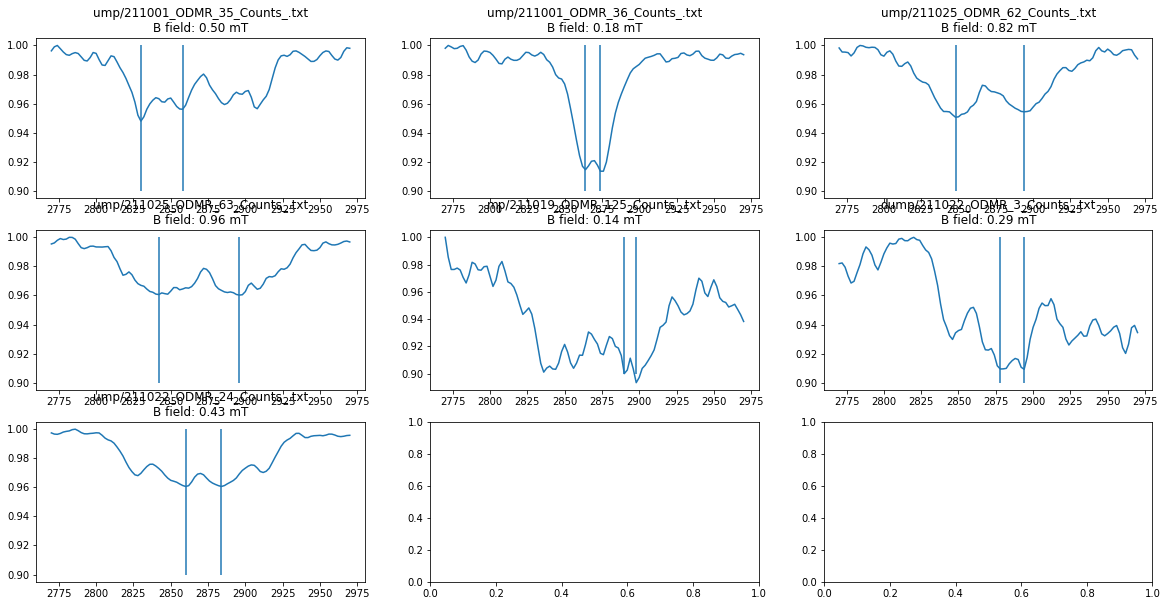

In [8]:
def find_peaks_sp(data, num_peaks):
    """ Find a specific number of peaks by finding the stationary points with the
    highest values in data. """
    diff = np.diff(data)
    # Find which values cross over zero
    prod = diff[1:] * diff[:-1]
    # prod will be negative where diff has crossed the x-axis
    sps = np.flatnonzero(prod < 0) + 1

    values = data[sps]
    pks = sps[values.argsort()[:num_peaks]]

    return pks

n_cols = 3

fig = plt.figure(figsize=(20,10))
axes = fig.subplots(
    nrows=(n_cols - 1 + len(good_freqs)) // n_cols, 
    ncols=n_cols, sharex="none").flatten()
for freq, s, ax, i in zip(good_freqs, full_good_specs, axes, good_specs):
    pks = find_peaks_sp(s, 2)
    if len(pks) < 2:
        print("Can't process peaks on %d" % i)
        continue
    ax.plot(freq, s)
    freq_pks = freq[pks]
    ax.vlines(freq_pks, ymin=0.9, ymax=1)
    freq_sep = abs(np.diff(freq_pks))
    b_field = freq_sep[0] / 56
    ax.set_title(f"{odmr_paths[i]}\nB field: {b_field:.2f} mT")
    print(f"Estimated B-field: {b_field:.2f} mT, freqs: {sorted(freq_pks)}")

plt.show()

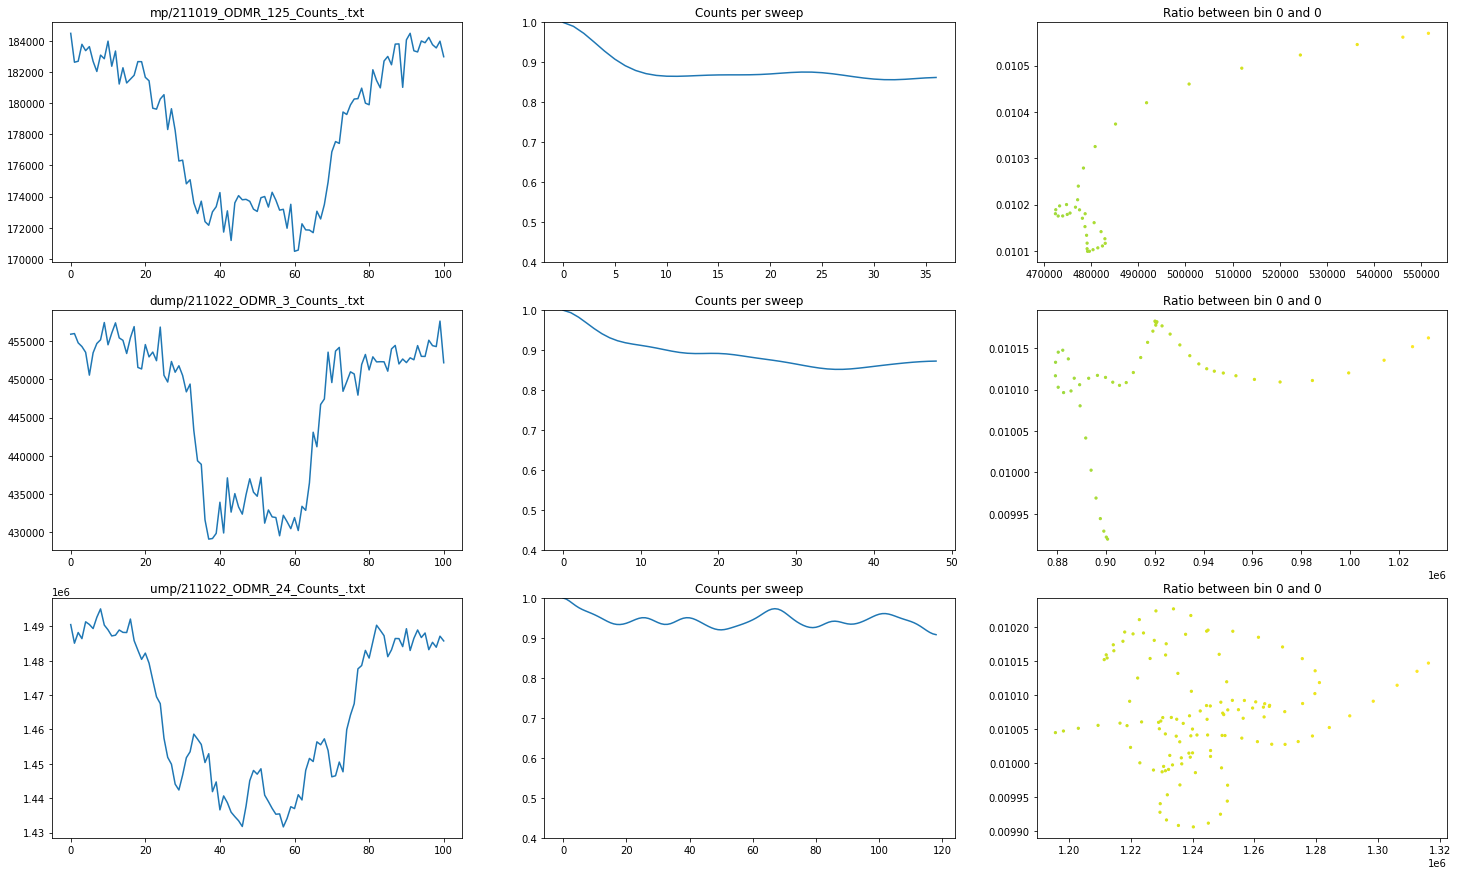

In [9]:
n_specs = len(odmr_specs)
n_rows = n_specs
fig = plt.figure(figsize=(25, n_rows*5))
axes = fig.subplots(nrows=n_rows, ncols=3)
edges = [0] * n_specs
for i, (spec, title, axis_row, x) in enumerate(zip(odmr_specs, odmr_paths, axes, edges)):
    left_ax, right_ax, third_ax = axis_row
    left_ax.set_title(title)
    right_ax.set_title("Counts per sweep")
    third_ax.set_title("Ratio between bin %d and 0" % x)
    counts = g_filter(spec.sum(axis=1), 3)
    left_ax.plot(spec.sum(axis=0))
    right_ax.plot(counts / max(counts))
    right_ax.set_ylim(0.4, 1)
    edge_counts = g_filter(spec[:, x], 3)
    edge_ref = g_filter(spec[:, 0], 3)
    try:
        third_ax.scatter(counts, edge_counts / counts, s=5, c=counts / max(counts), vmin=0)
    except:
        pass
plt.show()

In [10]:
nice_keys = [[f"{date}_{num}",(num, date)] for num, date in keys]

In [11]:
pol_axis = None
contrast_folded = None
def do_plot(time_per_bin, oscillation_period, phase, peak_bin=4, show_spec=False):
    """ time_per_bin is in milliseconds, oscillation_period is in seconds 
    """
    global pol_axis
    global contrast_folded
    fig = plt.figure(figsize=(20,14))
    time_per_bin *= 1e-3
    try:
        i = DI(*key_select.value)
        this_one = odmr_specs[i][range_selections[i]]
    except:
        print("Not a spec")
        return

    spec_plot, signal_plot, counts_plt, fold_plot = fig.subplots(nrows=2, ncols=2).flatten()
    if show_spec:
        spec_plot.set_title("ODMR Spectrum")
        the_data = this_one.sum(axis=0)
        the_data /= max(the_data)
        spec_plot.plot(freq_axes[i], the_data)
        spec_plot.scatter(freq_axes[i][peak_bin], the_data[peak_bin], c="red", s=100)
    n_sweeps = this_one.shape[0]
    bins_per_sweep = this_one.shape[1]
    print("Number of bins:", bins_per_sweep)
    t_ax = np.arange(n_sweeps) * time_per_bin * bins_per_sweep
    pol_v = 1/2 * (1 + np.sin(phase + t_ax * 2*np.pi/oscillation_period))
    # pol_ang = pol_v * 90
    counts_per_sweep = this_one.sum(axis=1)
    signal_plot.set_title("Counts vs time")
    signal_plot.set_xlabel("Time [s]")
    signal_plot.set_ylabel("Counts / Polarisation Rotator Voltage (arb)")
    signal_plot.plot(t_ax, counts_per_sweep)
    norm_factor = max(counts_per_sweep) - min(counts_per_sweep)
    signal_plot.plot(t_ax, pol_v * norm_factor + min(counts_per_sweep))

    counts_plt.set_title("Counts per sweep vs Polariser voltage")
    counts_plt.scatter(pol_v, counts_per_sweep)

    contrast = this_one[:, peak_bin] / this_one[:, 0]
    fold_plot.set_title("Contrast vs Polariser voltage")
    fold_plot.scatter(pol_v, contrast, label="Data")
    grad, const = np.polyfit(pol_v, contrast, 1)
    fold_plot.plot([0, 1], [const, const + grad], "orange", label="Gradient: %.2e"%grad)
    fold_plot.legend()

    pol_axis = pol_v
    contrast_folded = contrast

    plt.show()

key_select = wwid.Dropdown(options=nice_keys, description="Select experiment")
output = wwid.interactive(do_plot,
    date=wwid.Text(date10), time_per_bin=wwid.IntSlider(20, 0, 100),
    oscillation_period=wwid.FloatSlider(20, min=0, max=200, step=0.01, description="Period (s)"), 
    phase=wwid.FloatSlider(0, min=-np.pi, max=np.pi, step=0.01, description="Phase (rad)"),
    peak_bin=wwid.IntSlider(5, 0, 100))
output.children = (key_select, *output.children)
output

interactive(children=(Dropdown(description='Select experiment', options=(['211019_125', (125, '211019')], ['21…

delta = nan


C:\Users\Leo\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Leo\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


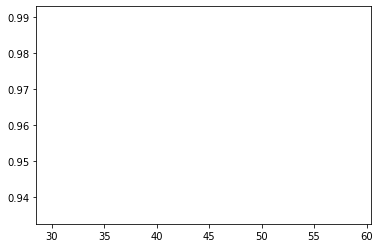

In [12]:
n_bins = 60
pol_bins = [list() for _ in range(n_bins)]
pol_axis_bins = ((pol_axis / max(pol_axis)) * (n_bins - 1)).astype(int)
for bin, cont in zip(pol_axis_bins, contrast_folded):
    pol_bins[bin].append(cont)

binned_average = [np.mean(bin) for bin in pol_bins]
grad, const = np.polyfit(np.arange(n_bins), binned_average, 1)
print("delta =", grad*n_bins)
plt.plot(binned_average)
plt.plot([0, n_bins], [const, const+grad*n_bins])
plt.show()

In [13]:
selected_bin = 24
@wwid.interact(selected_bin=wwid.IntSlider(0, 0, n_bins))
def contrast_plot(selected_bin):
    idx = DI(*key_select.value)
    data = odmr_specs[idx]

    selection = range_selections[idx]
    spec = data[selection][pol_axis_bins == selected_bin].sum(axis=0)
    spec = spec / max(spec)
    plt.plot(freq_axes[idx], spec)
    plt.show()

interactive(children=(IntSlider(value=0, description='selected_bin', max=60), Output()), _dom_classes=('widget…